# Meadow analysis

So now we have 15 sets of points representing mushrooms from our plots and 15 accompanying sets of polygons representing grass tufts. How do we test the hypothesis that they are spatially linked? 

### Set up our R environment

packages:

In [27]:
library('png')
library('sp')
library('maptools')
library('rgeos')
library('repr')

In [9]:
setwd("/home/daniel/Documents/Bitty_meadow_analysis/analysis")

load our function for digitizing grasses, "digpol()"

In [16]:
source('digpols.R')

Which, by the way, looks like this:

In [18]:
digpols

function () 
{
    require("sp")
    iter <- 1
    an <- "y"
    grasspols <- NULL
    allpols <- list()
    while (an != "n") {
        grass <- locator()
        grasspols <- Polygon(rbind(cbind(grass$x, grass$y), cbind(grass$x[1], 
            grass$y[1])))
        bb <- Polygons(list(grasspols), ID = paste("grass", iter, 
            sep = ""))
        allpols[[iter]] <- bb
        plot(SpatialPolygons(allpols), lwd = 2, add = TRUE)
        an <- readline(prompt = "Another(y/n)? ")
        if (an == "y") {
            iter <- iter + 1
        }
        else {
            break
        }
    }
    cc <- SpatialPolygons(allpols)
    return(cc)
}

## Finding distances to nearest grass-tuft neighbor of mushrooms

One of our plots looks like this, after digitizing: 

<img src='p3_06_sample_pols_mush.png'>

(The red triangles represent a mushroom or a cluster of mushrooms)

Let's simplify things a bit, and just deal with a few imaginary grass tufts and a few imaginary mushrooms:

In [50]:
p <- SpatialPoints(cbind(c(25,5,70),c(25,45,70)))

Use our digpols() function to draw some spatial polygons:

In [23]:
g <- digpols()

What does this look like?

In [59]:
options(repr.plot.width = 5, repr.plot.height = 5) ## using repr to control size of R plotter outputs

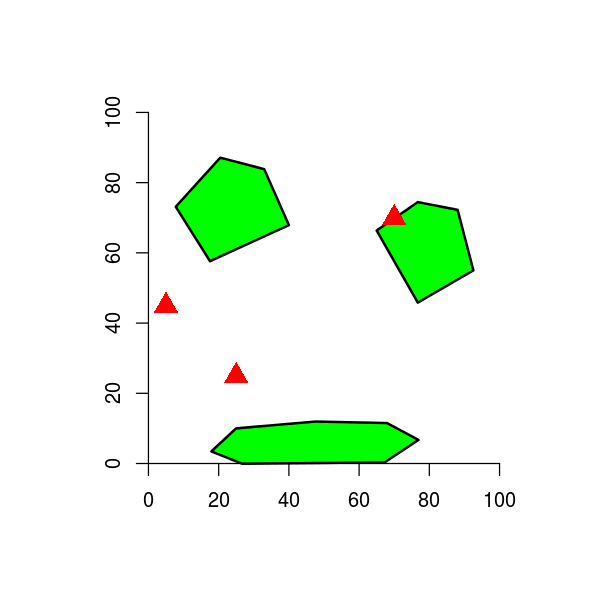

In [60]:
plot(g, lwd = 2, xlim = c(0,100), ylim = c(0,100), col = 'green')
plot(p, pch = 17, col = 'red', cex = 2, add = TRUE)
axis(1, pos = 0)
axis(2, pos = 0, at = c(0,100), labels = c('',''), lwd.ticks=0)
axis(2, pos = 0, at=seq(0,100, by = 20), lwd=0, lwd.ticks=1)

We need to know the distance to the nearest grass clump for each mushroom. We can get the distances using [gDistance()](https://cran.r-project.org/web/packages/rgeos/rgeos.pdf). Make sure to use the 'byid=TRUE' option:

In [61]:
dists <- gDistance(g, p, byid=TRUE); dists 

,grass1,grass2,grass3
1,33.46681,55.24240,14.93716
2,17.79230,63.68932,40.28856
3,30.0747643,0.1559771,58.5043044


We can then find the minimums of each row, and average all of these to get a representative statistic for the distances between mushrooms and grasses, in this plot. 

In [62]:
mindists <- apply(dists, MARGIN = 1, FUN = min)
avgmindists <- mean(mindists)
mindists

1          2          3 
14.9371591 17.7923043  0.1559771

In [63]:

avgmindists

[1] 10.96181

In this plot, on average, the nearest grass clump is 10.96 cm away from any given mushroom. Let's condense this process into a function:

In [64]:
avgNN <- function(grasses, mushrooms) {
        dists <- gDistance(grasses, mushrooms, byid=TRUE)
        mindists <- apply(dists, MARGIN=1, min)
        avgmindists <- mean(mindists)
        return(avgmindists)}

This will take our digitized mushroom and grass objects and tell us the average nearest neighbor distances between them:

In [66]:
 avgNN(grasses=g, mushrooms=p) 

[1] 10.96181

## Simulations

Now we test how often we get this distance or closer with the same spatial distribution of grass clumps, but with the same number of mushrooms, placed randomly over the plot. To generate a new set of mushrooms:

In [ ]:
yardstick = seq(from = 0, to = 100, by = 0.01)

xx <- sample(yardstick, size = length(p))
yy <- sample(yardstick, size = length(p))
p.random <- SpatialPoints(cbind(xx,yy))

We can condense turn this process into another function, that makes random sets of mushrooms of equal length to our actual mushrooms object:

In [73]:
mushrooms.random <- function(mushrooms){
        yardstick <- seq(from = 0,to = 100, by = 0.01)
        xx <- sample(yardstick, size = length(mushrooms))
        yy <- sample(yardstick, size = length(mushrooms))
        p.random <- SpatialPoints(cbind(xx,yy))
        return(p.random)
}

Try it out:

In [74]:
p.random <- mushrooms.random(mushrooms=p)

What do these look like?

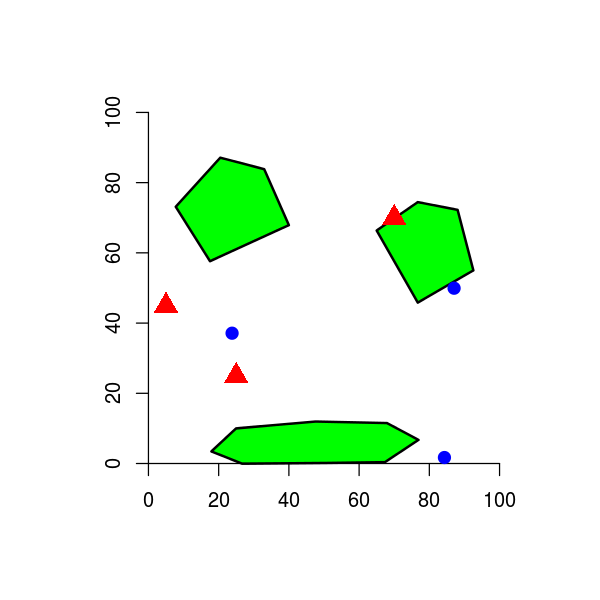

In [77]:
plot(g, lwd = 2, xlim = c(0,100), ylim = c(0,100), col = 'green')
plot(p, pch = 17, col = 'red', cex = 2, add = TRUE)
axis(1, pos = 0)
axis(2, pos = 0, at = c(0,100), labels = c('',''), lwd.ticks=0)
axis(2, pos = 0, at=seq(0,100, by = 20), lwd=0, lwd.ticks=1)
plot(p.random, add=TRUE, col = 'blue', pch = 20, cex = 2)

(New, random mushrooms are blue dots)

We can use our function from above to see the average distance between nearest mushrooms and grasses in this random set of mushrooms:

In [76]:
avgNN(grasses=g, mushrooms=p.random)

[1] 10.66636

So now we need to generate a lot of these random sets of mushrooms, and see how often they fall as close or closer to grasses. Do this with a function, with an output in the form of  probability seeing an observed average distance result or closer:

In [78]:
getpval <- function(grasses, mushrooms, iterations) {
        avgNN.obs <- avgNN(grasses=grasses, mushrooms=mushrooms)
        avgNN.ran <- NULL
        for(i in 1:iterations){
                avgNN.ran[i] <- avgNN(grasses=grasses, mushrooms = mushrooms.random(mushrooms=mushrooms))}
        pval <- sum(avgNN.ran <= avgNN.obs)/ length(avgNN.ran)
        return(pval)
        }


So for example, with the above set of grasses, mushrooms, and 5000 iterations: 

In [81]:
getpval(grasses=g,mushrooms=p,iterations=5000)

[1] 0.5304

If mushrooms are distributed completely spatially randomly, ~53% of the time we expect to see that mushrooms are as close to grasses as we observed, or closer.

Now we repeat this for all of our actual digitized plots, correct for multiple tests (FDR/Benjamini-Hochberg), and see if a trend emerges.